In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from Bio.Seq import Seq
import math
from sklearn import mixture

Let's first import our selection coefficients for the CDS spike-ins as well as the data from Després et al. (2022)

In [4]:
s_CDS_SA = pd.read_csv("Supp_data/median_s_CDS.csv")
FC_scores_PD = pd.read_csv("Després_supp_data/S_data_6.csv", index_col=0)

In [5]:
s_CDS_SA.columns

Index(['Genotype', 'Position (codon)', 'Included_position', 'In spike-in',
       'Mutation types', 'N_T0', 'N_T3', 'Median_s_T0toT2', 'Min_s', 'Max_s',
       'not_zero_p-val', 'n_observed', 'not_zero_FDR'],
      dtype='object')

Because Després et al.'s data is expressed by amino acid, we first need to convert our mutant IDs into codons and corresponding amino acids 

## Converting genotype IDs into codons and amino acids

### Importing the reference CDS as a dictionary of position -> codon

In [9]:
# Defining a function to create dictionaries of codons
def wt_codon_dict(cds_seq):
    codons_dict = {}

    for index, base in enumerate(cds_seq):
        nt_pos = index + 1  # Because emumerate will be 0-based
        codon_number = math.ceil(nt_pos/3)
        bounds = ((codon_number*3)-2, codon_number*3)
        wt_codon = cds_seq[bounds[0]-1:bounds[1]]
        wt_aa = str(Seq(wt_codon).translate())

        codons_dict[codon_number] = [bounds, wt_codon, wt_aa]

    return codons_dict

In [10]:
# Importing the FCY1 coding sequence and generaring the dict
# This is the CODON-OPTIMIZED sequence, which was used by Després et al. (2022)
fcy1_opt = "ATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTTGATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAGGTAAGGTCTATAAGGACACCACCTTGTACACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGAACGTCCACAAGACTGGTTCGAAGATATTGGTGAATGA"
fcy1_codons = wt_codon_dict(fcy1_opt)

### Adding codon and aa information to the genotypes from the current screen

In [12]:
# Defining a function to extract the mutated positions and the corresponding mutations into a dictionary
def codes_to_dict(mut_codes, seq_start):
    """seq_start is the position (1-based, nucleotides) where the sequenced region begins within the CDS."""
    muts_dict = {}
    seq_to_add = seq_start - 1

    codes_list = mut_codes.split(', ')

    for mut_code in codes_list:
        begin_mut = int(mut_code.split('_')[0].split('-')[1])
        end_mut = begin_mut + (int(mut_code.split('_')[1].split('nt')[0]) -1)
        mut_letters = mut_code.split('to')[1]
        mut_coords = list(range(begin_mut, end_mut+1))

        mut_length = (end_mut - begin_mut) + 1

        temp_dict = {(mut_coords[n] + seq_to_add): mut_letters[n] for n in range(mut_length)}
        muts_dict.update(temp_dict)

    return muts_dict

In [13]:
# Iterating cleanly on the rows requires renaming many columns
s_CDS_SA = s_CDS_SA.rename(columns={'Position (codon)': 'Num_codon', 'In spike-in': 'In_spike-in',
                                    'Mutation types': 'Mutation_types'})

In [14]:
seq_start = 193 # The sequenced region begins at nucleotide 193 of the FCY1 CDS
s_CDS_SA['New_codon'] = 'Problem'

# Iterating on each row to assemble the corresponding new codon
for cds_row in s_CDS_SA.itertuples():
    row_id = cds_row.Index
    mut_ids = cds_row.Genotype
    codon_num = cds_row.Num_codon

    # For the current genotype, making a dictionary of mutated positions
    muts_dict = codes_to_dict(mut_ids, seq_start)

    # Making a similar dictionary (pos -> nt) for the WT codon
    codon_bounds = fcy1_codons[codon_num][0]
    codon_coords = list(range(codon_bounds[0], codon_bounds[1]+1))
    wt_codon = fcy1_codons[codon_num][1]
    wt_dict = {codon_coords[n]: wt_codon[n] for n in range(3)}

    # Reconstruct the mutated codon using the two dictionaries
    mut_codon = ''
    for nt_pos in codon_coords:

        if nt_pos in muts_dict.keys():
            mut_codon += muts_dict[nt_pos]

        elif nt_pos not in muts_dict.keys():
            mut_codon += wt_dict[nt_pos]

    # Adding the mutated codon to the dataframe
    s_CDS_SA.at[row_id, 'New_codon'] = mut_codon

In [15]:
# Adding the mutated aa, as well as wt codon and aa
s_CDS_SA['Mut_aa'] = s_CDS_SA['New_codon'].apply(lambda x: str(Seq(x).translate()))
s_CDS_SA['WT_codon'] = s_CDS_SA['Num_codon'].apply(lambda x: fcy1_codons[x][1])
s_CDS_SA['WT_aa'] = s_CDS_SA['Num_codon'].apply(lambda x: fcy1_codons[x][2])

### Computing median selection coefficients by aa

In [17]:
# Selecting only the genotypes which were part of the "spike-ins"
s_CDS_calc = s_CDS_SA[s_CDS_SA['In_spike-in'] == True].copy().reset_index(drop=True)

In [18]:
s_CDS_SA_byaa = s_CDS_calc[['Num_codon', 'WT_codon', 'WT_aa', 'Mut_aa', 'Median_s_T0toT2']].groupby(by=['Num_codon', 'WT_codon', 'WT_aa', 'Mut_aa'], as_index=False).median()
s_CDS_SA_max = s_CDS_calc[['Num_codon', 'WT_codon', 'WT_aa', 'Mut_aa', 'Median_s_T0toT2']].groupby(by=['Num_codon', 'WT_codon', 'WT_aa', 'Mut_aa'], as_index=False).max()
s_CDS_SA_max = s_CDS_SA_max.rename(columns={'Median_s_T0toT2': 'Max_med_s'})
s_CDS_SA_min = s_CDS_calc[['Num_codon', 'WT_codon', 'WT_aa', 'Mut_aa', 'Median_s_T0toT2']].groupby(by=['Num_codon', 'WT_codon', 'WT_aa', 'Mut_aa'], as_index=False).min()
s_CDS_SA_min = s_CDS_SA_min.rename(columns={'Median_s_T0toT2': 'Min_med_s'})

s_CDS_SA_byaa = pd.merge(s_CDS_SA_byaa, s_CDS_SA_min, on=['Num_codon', 'WT_codon', 'WT_aa', 'Mut_aa'], how='outer')
s_CDS_SA_byaa = pd.merge(s_CDS_SA_byaa, s_CDS_SA_max, on=['Num_codon', 'WT_codon', 'WT_aa', 'Mut_aa'], how='outer')

In [19]:
# Identifying synonymous substitutions
s_CDS_SA_byaa['Synonymous'] = (s_CDS_SA_byaa['WT_aa'] == s_CDS_SA_byaa['Mut_aa'])

In [20]:
s_CDS_SA_byaa[s_CDS_SA_byaa['Synonymous'] == True]

,Num_codon,WT_codon,WT_aa,Mut_aa,Median_s_T0toT2,Min_med_s,Max_med_s,Synonymous
8,65,ATC,I,I,-0.027964,-0.054849,-0.001080,True
25,69,GAA,E,E,-0.052934,-0.052934,-0.052934,True
53,70,AAC,N,N,-0.061507,-0.061507,-0.061507,True
64,71,TGT,C,C,-0.069653,-0.069653,-0.069653,True
93,74,TTG,L,L,-0.116201,-0.371520,-0.072107,True
108,75,GAA,E,E,-0.092293,-0.092293,-0.092293,True
131,76,GGT,G,G,-0.111947,-0.120797,-0.052856,True
162,83,ACC,T,T,-0.070777,-0.078332,-0.063223,True
182,89,TCA,S,S,0.123350,-0.110837,0.615693,True
224,95,ACT,T,T,-0.073516,-0.074210,-0.072822,True


In [21]:
s_CDS_SA[(s_CDS_SA['Num_codon'] == 89) & (s_CDS_SA['Mut_aa'] == 'S')]

,Genotype,Num_codon,Included_position,In_spike-in,Mutation_types,N_T0,N_T3,Median_s_T0toT2,Min_s,Max_s,not_zero_p-val,n_observed,not_zero_FDR,New_codon,Mut_aa,WT_codon,WT_aa
718,S-73_3nt_TCAtoAGC,89,True,True,['Substitution'],2302.0,1147.5,0.267791,0.239017,0.335819,3.119365e-07,8.0,6.174013e-07,AGC,S,TCA,S
720,S-73_3nt_TCAtoAGT,89,True,True,['Substitution'],512.5,2977.0,0.615693,0.539762,0.657543,1.102358e-09,8.0,2.703469e-09,AGT,S,TCA,S
752,S-75_1nt_AtoC,89,True,True,['Substitution'],4198.5,167.0,0.123350,0.064689,0.152079,8.507337e-05,8.0,1.475636e-04,TCC,S,TCA,S
756,S-75_1nt_AtoG,89,True,True,['Substitution'],5485.5,13.5,-0.083076,-0.254784,0.008049,1.619951e-02,8.0,2.204613e-02,TCG,S,TCA,S
760,S-75_1nt_AtoT,89,True,True,['Substitution'],1306.5,11.5,-0.110837,-0.282945,0.013873,2.323090e-02,8.0,3.019384e-02,TCT,S,TCA,S


**THIS IS WEIRD** (and AGT at position 89 does not confer resistance in Philippe's data). Could this mean that there is a problem with codon numbers???

Considering that almost all medians for synonymous substitutions are close to 0 - while close to half of all mutations confer resistance in the original study -, this seems unlikely. However, the sequencing region for F2 in Després et al. is not the same used here. As such, these puzzling beneficial effects for serine at codon 89 could be due to secondary mutations  which were sequenced in the original study, but not in our current work. We note that the mutant library for each position was constructed only once in Després et al. (2022).

#### Looking at variance within synonymous codon substitutions

In [25]:
s_CDS_calc['Synonymous'] = (s_CDS_calc['WT_aa'] == s_CDS_calc['Mut_aa'])
s_CDS_syn = s_CDS_calc[s_CDS_calc['Synonymous'] == True].copy().reset_index(drop=True)

<Axes: xlabel='Num_codon', ylabel='Median_s_T0toT2'>

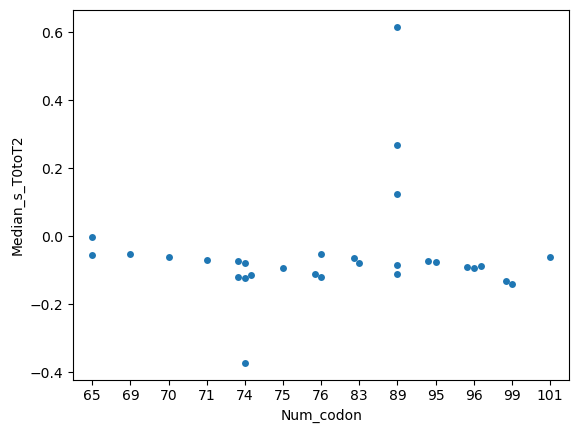

In [26]:
sns.swarmplot(data=s_CDS_syn, x='Num_codon', y='Median_s_T0toT2')

Codon 89 (serine) is the only one for which there is an obvious problem.

**Codon 100 is missing, because it is a methionine, for which there is no synonymous codon**

#### Comparing distributions for synonymous, missense and nonsense mutations

In [30]:
s_CDS_calc['Variant_type'] = s_CDS_calc['Mut_aa'].apply(lambda x: 'Nonsense' if x=='*' else 'Missense')

s_CDS_calc['Variant_type'] = s_CDS_calc.apply(lambda x: 'Synonymous' if x.Synonymous else x.Variant_type, axis=1)

<Axes: xlabel='Variant_type', ylabel='Median_s_T0toT2'>

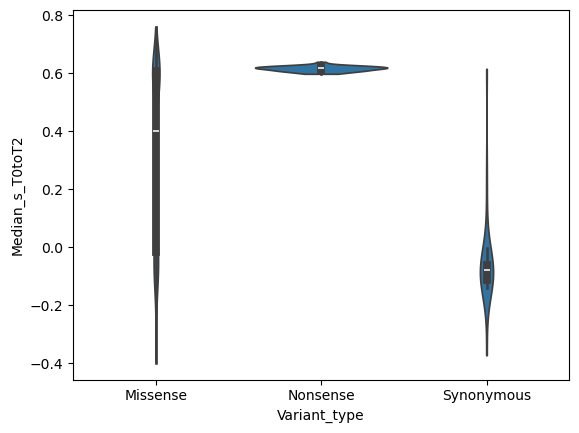

In [31]:
# By genotype
sns.violinplot(data=s_CDS_calc, x='Variant_type', y='Median_s_T0toT2', cut=0, order=['Missense', 'Nonsense', 'Synonymous'])

<Axes: xlabel='Variant_type', ylabel='Median_s_T0toT2'>

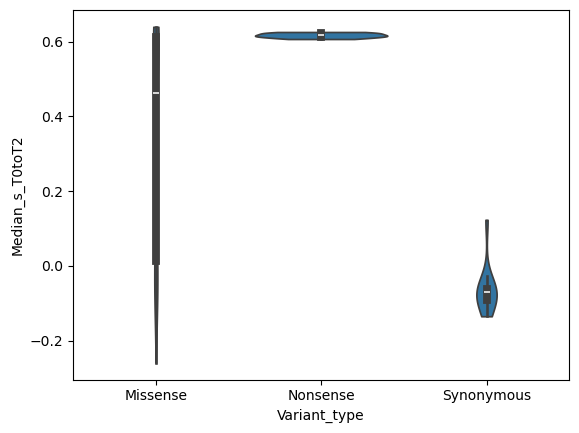

In [32]:
# By aa
s_CDS_SA_byaa['Variant_type'] = s_CDS_SA_byaa['Mut_aa'].apply(lambda x: 'Nonsense' if x=='*' else 'Missense')
s_CDS_SA_byaa['Variant_type'] = s_CDS_SA_byaa.apply(lambda x: 'Synonymous' if x.Synonymous else x.Variant_type, axis=1)

sns.violinplot(data=s_CDS_SA_byaa, x='Variant_type', y='Median_s_T0toT2', cut=0, order=['Missense', 'Nonsense', 'Synonymous'])

In general, this makes sense!

## Comparing the variant effects

### Comparing the selection coefficients and FC scores

For now, we will compare the FC scores as reported by Després et al. (2022), aggregated by amino acid.

In [37]:
# Renaming columns in the Després df
FC_scores_PD = FC_scores_PD.rename(columns={'codon': 'Num_codon', 'wt': 'WT_aa',
                                           'measured': 'Mut_aa'})

s_aa_merged = pd.merge(s_CDS_SA_byaa, FC_scores_PD[['Num_codon', 'WT_aa', 'Mut_aa', 'FC_score']],
                       on=['Num_codon', 'WT_aa', 'Mut_aa'], how='left')

What does the correlation look like?

Text(-0.1, 0.65, '$\\rho$ = 0.782\np-val = 2.589e-65')

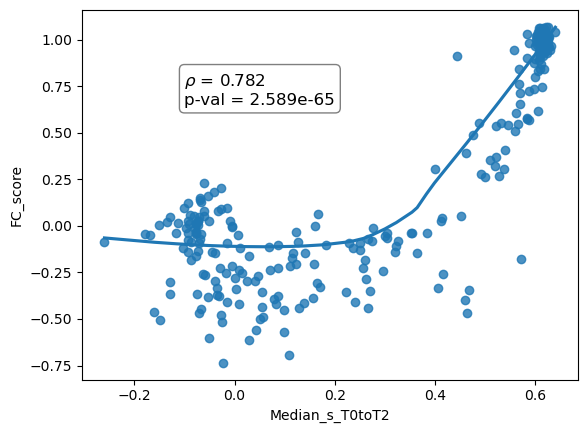

In [39]:
sns.regplot(data=s_aa_merged, x='Median_s_T0toT2', y='FC_score', lowess=True)

# Compute spearman rho
calc_subset = s_aa_merged.dropna(subset=['Median_s_T0toT2', 'FC_score']).reset_index(drop=True)
spearman_coeff = stats.spearmanr(calc_subset['Median_s_T0toT2'], calc_subset['FC_score'])
plt.annotate(r"$\rho$ = "f'{round(spearman_coeff[0], 3)}\np-val = {spearman_coeff[1]:.3e}',
             (-0.1, 0.65), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)

Text(-0.1, 0.65, '$\\rho$ = 0.727\np-val = 8.627e-33')

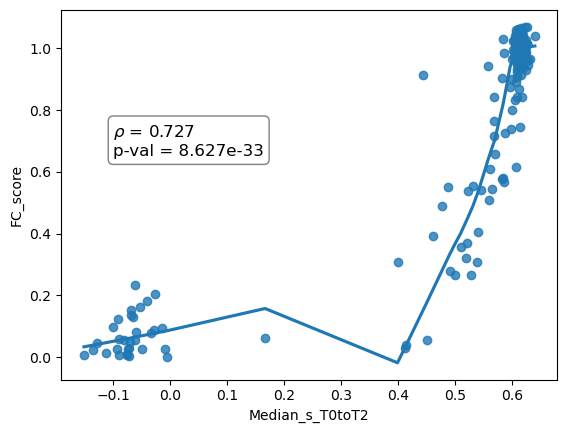

In [40]:
# Repeating the same only for amino acids which were called as FC > 0 in Després et al.
pos_FC = s_aa_merged[s_aa_merged['FC_score'] > 0].copy().reset_index(drop=True)

sns.regplot(data=pos_FC, x='Median_s_T0toT2', y='FC_score', lowess=True)

# Compute spearman rho
calc_subset = pos_FC.dropna(subset=['Median_s_T0toT2', 'FC_score']).reset_index(drop=True)
spearman_coeff = stats.spearmanr(calc_subset['Median_s_T0toT2'], calc_subset['FC_score'])
plt.annotate(r"$\rho$ = "f'{round(spearman_coeff[0], 3)}\np-val = {spearman_coeff[1]:.3e}',
             (-0.1, 0.65), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)

We basically only agree on resistant calls, but the agreement is extremely high!

A good demonstration of this agreement might be the frequency of discordant classification in "susceptible" or "resistant" categories.

### Assessing the frequency of discordant classifications as "resistant" or "susceptible"

#### Identifying "resistant" and "susceptible" calls within each dataset, by amino acid

Let's first plot the distributions

Text(0.5, 1.0, 'Després et al. (2022)')

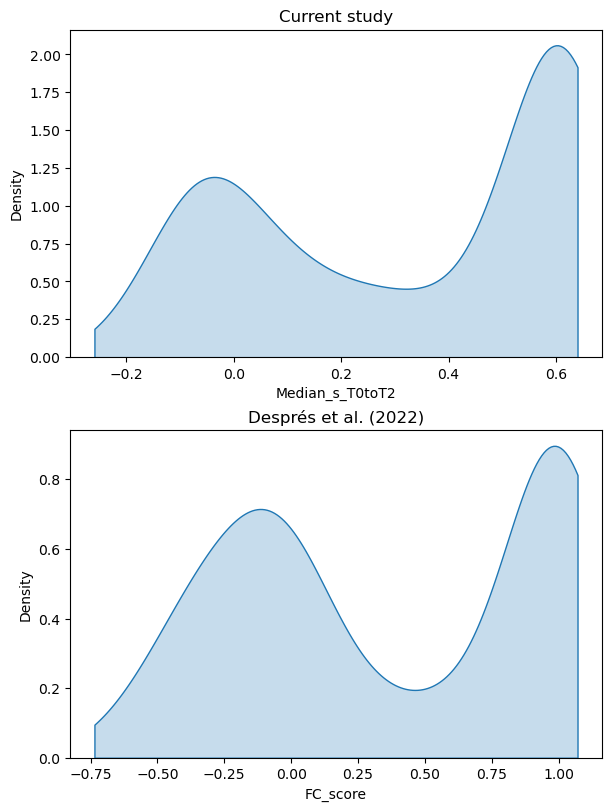

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)

sns.kdeplot(data=s_aa_merged, x='Median_s_T0toT2', cut=0, fill=True, ax=axs[0])
axs[0].set_title('Current study')

sns.kdeplot(data=s_aa_merged, x='FC_score', cut=0, fill=True, ax=axs[1])
axs[1].set_title('Després et al. (2022)')

Both distributions are similarly bimodal and can resonably be modeled by a mixture of two normal distributions. 

Fitting Gaussian mixture models

In [49]:
# For our selection coefficients
fit_SA = mixture.GaussianMixture(n_components=2, random_state=12, covariance_type='tied').fit(np.array(s_aa_merged['Median_s_T0toT2']).reshape(-1, 1))
# For the Després et al. FC scores
fit_PD = mixture.GaussianMixture(n_components=2, random_state=12, covariance_type='tied').fit(np.array(s_aa_merged['FC_score']).reshape(-1, 1))

F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [50]:
print(f'Means for SA = ({fit_SA.means_[0]}, {fit_SA.means_[1]})')
#print(f'SDs for SA = ({fit_SA.covariances_[0]}, {fit_SA.covariances_[1]})')
print(f'SDs for SA = ({fit_SA.covariances_[0]})')

Means for SA = ([0.01130905], [0.57342603])
SDs for SA = ([0.01007859])


In [51]:
print(f'Means for PD = ({fit_PD.means_[0]}, {fit_PD.means_[1]})')
#print(f'SDs for PD = ({fit_PD.covariances_[0]}, {fit_PD.covariances_[1]})')
print(f'SDs for PD = ({fit_PD.covariances_[0]})')

Means for PD = ([-0.14565376], [0.93654997])
SDs for PD = ([0.03682736])


In [52]:
# Getting the labels from the models for each aa
s_aa_merged['Label_SA'] = fit_SA.predict(np.array(s_aa_merged['Median_s_T0toT2']).reshape(-1, 1))
s_aa_merged['Label_PD'] = fit_PD.predict(np.array(s_aa_merged['FC_score']).reshape(-1, 1))

In [53]:
s_aa_merged

,Num_codon,WT_codon,WT_aa,Mut_aa,Median_s_T0toT2,Min_med_s,Max_med_s,Synonymous,Variant_type,FC_score,Label_SA,Label_PD
0,65,ATC,I,*,0.625398,0.618454,0.632343,False,Nonsense,0.986618,1,1
1,65,ATC,I,A,0.624161,0.594500,0.630521,False,Missense,0.928501,1,1
2,65,ATC,I,C,0.617546,0.617353,0.617739,False,Missense,0.842884,1,1
3,65,ATC,I,D,0.615864,0.601317,0.630411,False,Missense,0.993405,1,1
4,65,ATC,I,E,0.627980,0.624930,0.631029,False,Missense,0.961594,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
306,101,TAC,Y,S,0.546353,0.533163,0.586696,False,Missense,0.542323,1,1
307,101,TAC,Y,T,0.043104,-0.308583,0.061251,False,Missense,-0.556617,0,0
308,101,TAC,Y,V,0.383074,0.357603,0.502849,False,Missense,-0.039937,1,0
309,101,TAC,Y,W,0.236272,0.236272,0.236272,False,Missense,-0.120034,0,0


<Axes: xlabel='FC_score', ylabel='Count'>

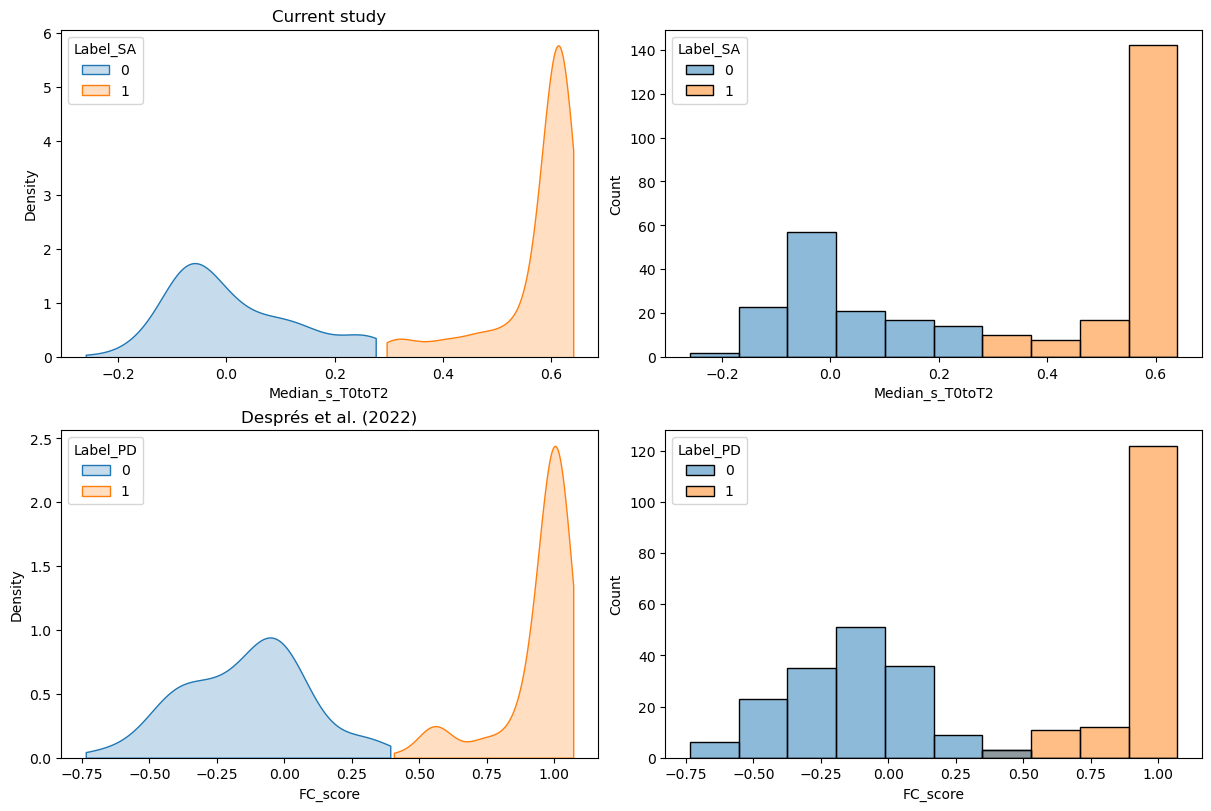

In [54]:
# Looking at the distributions, with labels
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

sns.kdeplot(data=s_aa_merged, x='Median_s_T0toT2', hue='Label_SA', cut=0, fill=True, ax=axs[0,0])
axs[0,0].set_title('Current study')
sns.histplot(data=s_aa_merged, x='Median_s_T0toT2', hue='Label_SA', ax=axs[0,1])

sns.kdeplot(data=s_aa_merged, x='FC_score', hue='Label_PD', cut=0, fill=True, ax=axs[1,0])
axs[1,0].set_title('Després et al. (2022)')
sns.histplot(data=s_aa_merged, x='FC_score', hue='Label_PD', ax=axs[1,1])

By using 'tied' covariance matrices, the cutoff between the two components lines up well with the "lowest point" of the overall distributions, as seen on the density plots above.

Let's use these labels to assess the agreement between the two experiments, regarding the classification of amino acid substitutions as "susceptible" or "resistant" to 5-FC.

In [57]:
dict_labels = {0: 'Susceptible', 1:'Resistant'}
s_aa_merged['Label_SA'] = s_aa_merged['Label_SA'].apply(lambda x: dict_labels[x])
s_aa_merged['Label_PD'] = s_aa_merged['Label_PD'].apply(lambda x: dict_labels[x])

In [58]:
s_aa_merged['Class_outcome'] = ''
s_aa_merged['occurences'] = 1

# Adding classification outcomes
# Choices: 
# Resistant_both
# Susceptible_both
# Res_SA_only
# Res_PD_only
for row in s_aa_merged.itertuples():
    row_id = row.Index
    lab_SA = row.Label_SA
    lab_PD = row.Label_PD

    if lab_SA == lab_PD:

        if lab_SA == 'Resistant':
            s_aa_merged.at[row_id, 'Class_outcome'] = 'Resistant_both'

        elif lab_SA == 'Susceptible':
            s_aa_merged.at[row_id, 'Class_outcome'] = 'Susceptible_both'

    elif lab_SA != lab_PD:

        if lab_SA == 'Resistant':
            s_aa_merged.at[row_id, 'Class_outcome'] = 'Res_SA_only'

        elif lab_SA == 'Susceptible':
            s_aa_merged.at[row_id, 'Class_outcome'] = 'Res_PD_only'

In [59]:
s_aa_merged[['Label_SA', 'Label_PD', 'occurences']].groupby(by=['Label_SA', 'Label_PD'], as_index=False).sum().pivot(columns='Label_PD', index='Label_SA', values='occurences')

Label_PD,Resistant,Susceptible
Label_SA,,
Resistant,148.0,29.0
Susceptible,NaN,134.0


**All amino acid substitutions which are in the "resistant" cluster in Després et al. (2022) are also in this cluster in our "spike-ins"!**

#### Additionally, we can compute the percentiles for each score and look at the deviations between the two experiments:

In [62]:
s_aa_merged['Percentile_SA'] = s_aa_merged['Median_s_T0toT2'].rank(pct=True)
s_aa_merged['Percentile_PD'] = s_aa_merged['FC_score'].rank(pct=True)

Text(0.1, 0.65, 'r = 0.782\np-val = 2.589e-65')

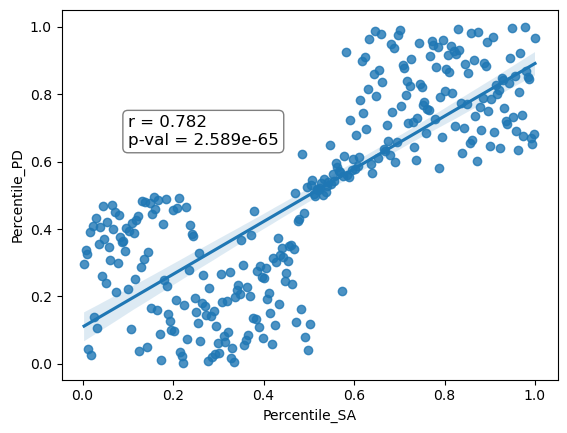

In [63]:
sns.regplot(data=s_aa_merged, x='Percentile_SA', y='Percentile_PD')

calc_subset = s_aa_merged.dropna(subset=['Percentile_SA', 'Percentile_PD']).reset_index(drop=True)
pearson_coeff = stats.pearsonr(calc_subset['Percentile_SA'], calc_subset['Percentile_PD'])
plt.annotate(r"r = "f'{round(pearson_coeff[0], 3)}\np-val = {pearson_coeff[1]:.3e}',
             (0.1, 0.65), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)

This is not especially informative. It shows that the two experiments agree about the cluster membership of each amino acid substitution, but not about ranks within the two clusters. 

## Comparing CDS and promoter mutations

### Identifying amino acid substitutions which are accessible by single-nucleotide substitutions

Using the **native** FCY1 sequence, let's compile which amino acid variants can be obtained through single-nucleotide changes

In [68]:
wt_fcy1 = "atggtgacagggggaatggcaagcaagtgggatcagaagggtatggacattgcctatgaggaggcggccttaggttacaaagagggtggtgttcctattggcggatgtcttatcaataacaaagacggaagtgttctcggtcgtggtcacaacatgagatttcaaaagggatccgccacactacatggtgagatctccactttggaaaactgtgggagattagagggcaaagtgtacaaagataccactttgtatacgacgctgtctccatgcgacatgtgtacaggtgccatcatcatgtatggtattccacgctgtgttgtcggtgagaacgttaatttcaaaagtaagggcgagaaatatttacaaactagaggtcacgaggttgttgttgttgacgatgagaggtgtaaaaagatcatgaaacaatttatcgatgaaagacctcaggattggtttgaagatattggtgagtag"
wt_fcy1 = wt_fcy1.upper()

In [69]:
native_codons = wt_codon_dict(wt_fcy1)

In [70]:
muts_model = pd.DataFrame(columns=['Num_codon', 'WT_codon', 'WT_aa', 'Mut_codon', 'Mut_aa', 'Variant_type'])

codon_range = range(1, 160)

n_iter = 0

for codon_num in codon_range:
    dict_entry = native_codons[codon_num]
    wt_nt = dict_entry[1]
    wt_aa = dict_entry[2]

    # Make all single substitutions in the WT codon
    for nt_pos in [0, 1, 2]:

        for nt_code in ['A', 'T', 'G', 'C']:

            if nt_code == wt_nt[nt_pos]:
                continue
                
            elif nt_code != wt_nt[nt_pos]:
                codon_as_list = list(wt_nt)
                codon_as_list[nt_pos] = nt_code
                new_codon = ('').join(codon_as_list)
                new_aa = str(Seq(new_codon).translate())

                if new_aa == wt_aa:
                    var_type = 'Synonymous'

                elif new_aa != wt_aa:

                    if new_aa == '*':
                        var_type = 'Nonsense'

                    else:
                        var_type = 'Missense'

            current_mut = muts_model.copy()

            current_mut.at[0, 'Num_codon'] = codon_num
            current_mut.at[0, 'WT_codon'] = wt_nt
            current_mut.at[0, 'WT_aa'] = wt_aa
            current_mut.at[0, 'Mut_codon'] = new_codon
            current_mut.at[0, 'Mut_aa'] = new_aa
            current_mut.at[0, 'Variant_type'] = var_type

            if n_iter == 0:
                fcy1_muts_1nt = current_mut.copy()

            elif n_iter > 0:
                fcy1_muts_1nt = pd.concat([fcy1_muts_1nt, current_mut]).reset_index(drop=True)

            n_iter += 1

In [71]:
# Merging with the fitness measurements from Després et al. (2022):
fcy1_muts_1nt = pd.merge(fcy1_muts_1nt, FC_scores_PD[['Num_codon', 'WT_aa', 'Mut_aa', 'FC_score']].copy(),
                         on= ['Num_codon', 'WT_aa', 'Mut_aa'], how='left')

In [72]:
fcy1_muts_1nt[fcy1_muts_1nt['FC_score'].isna()]

,Num_codon,WT_codon,WT_aa,Mut_codon,Mut_aa,Variant_type,FC_score
0,1,ATG,M,TTG,L,Missense,NaN
1,1,ATG,M,GTG,V,Missense,NaN
2,1,ATG,M,CTG,L,Missense,NaN
3,1,ATG,M,AAG,K,Missense,NaN
4,1,ATG,M,AGG,R,Missense,NaN
5,1,ATG,M,ACG,T,Missense,NaN
6,1,ATG,M,ATA,I,Missense,NaN
7,1,ATG,M,ATT,I,Missense,NaN
8,1,ATG,M,ATC,I,Missense,NaN
253,29,GGT,G,TGT,C,Missense,NaN


In [73]:
print(f'This excludes {fcy1_muts_1nt[fcy1_muts_1nt['FC_score'].isna()].shape[0]} single nucleotide substitutions, out of {fcy1_muts_1nt.shape[0]}')

This excludes 20 single nucleotide substitutions, out of 1431


#### What does the distribution of effects look like?

<Axes: xlabel='FC_score', ylabel='Count'>

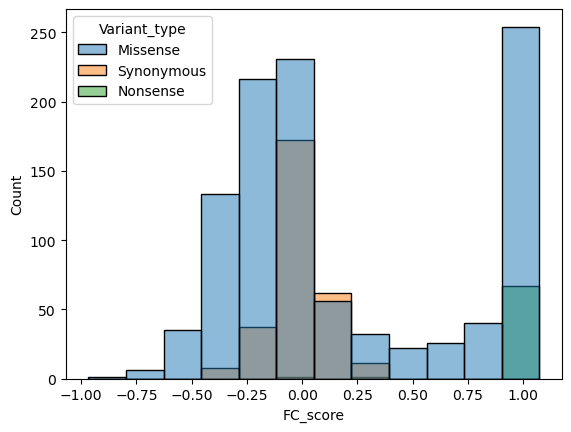

In [75]:
sns.histplot(data=fcy1_muts_1nt, x='FC_score', hue='Variant_type')

### Assessing the prevalence of resistance-conferring mutations

Let's start by training a Gaussian mixture model as previously, but on the full set of FC scores from Després et al. (2022)

In [78]:
fit_FC_full = mixture.GaussianMixture(n_components=2, random_state=12, covariance_type='tied').fit(np.array(FC_scores_PD['FC_score'].dropna()).reshape(-1, 1))

<Axes: xlabel='FC_score', ylabel='Count'>

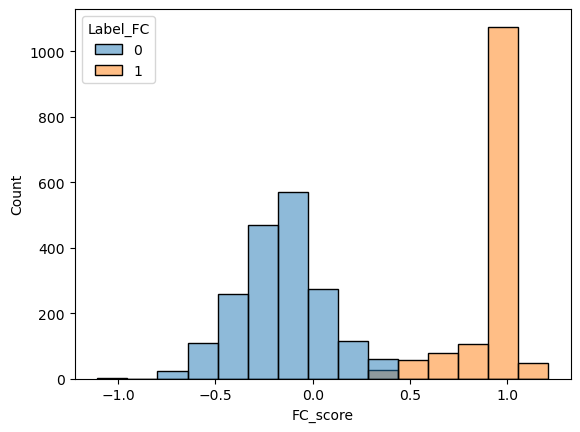

In [79]:
# Assessing the fit
FC_PD_noNaNs = FC_scores_PD.dropna(subset=['FC_score']).copy().reset_index(drop=True)
FC_PD_noNaNs['Label_FC'] = fit_FC_full.predict(np.array(FC_PD_noNaNs['FC_score']).reshape(-1, 1))

sns.histplot(data=FC_PD_noNaNs, x='FC_score', hue='Label_FC')

It works as good as previously, when only the "spike-in" positions were included. This figure highlights that the proportion of resistance-conferring mutations is much lower when only single-nucleotide changes are considered!

<Axes: xlabel='FC_score', ylabel='Count'>

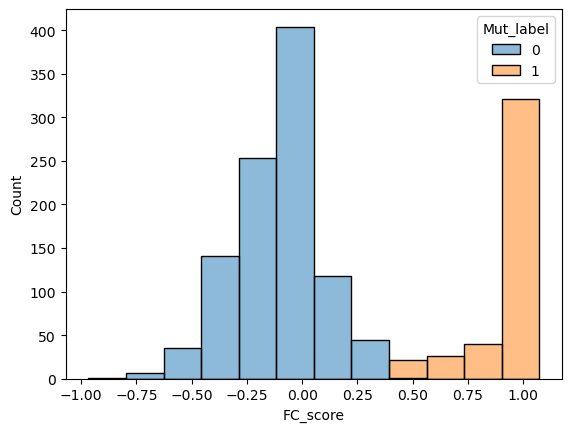

In [81]:
# Making the same plot for single-nucleotide substitutions
fcy1_muts_1nt = fcy1_muts_1nt.dropna(subset=['FC_score']).copy().reset_index(drop=True)
fcy1_muts_1nt['Mut_label'] = fit_FC_full.predict(np.array(fcy1_muts_1nt['FC_score']).reshape(-1, 1))

sns.histplot(data=fcy1_muts_1nt, x='FC_score', hue='Mut_label')

In [82]:
frac_res = (np.sum(fcy1_muts_1nt['Mut_label']) / fcy1_muts_1nt.shape[0])*100

print(f'{frac_res} % of single-nucleotide substitutions in FCY1 confer resistance to 5-FC')
print(f'{np.sum(fcy1_muts_1nt['Mut_label'])} / {fcy1_muts_1nt.shape[0]}')

28.915662650602407 % of single-nucleotide substitutions in FCY1 confer resistance to 5-FC
408 / 1411


In [83]:
fcy1_muts_1nt[(fcy1_muts_1nt['Mut_aa'] == '*') & (fcy1_muts_1nt['Mut_label'] == 1)]

,Num_codon,WT_codon,WT_aa,Mut_codon,Mut_aa,Variant_type,FC_score,Mut_label
63,9,AAG,K,TAG,*,Nonsense,0.972870,1
75,10,TGG,W,TAG,*,Nonsense,0.960428,1
78,10,TGG,W,TGA,*,Nonsense,0.960428,1
91,12,CAG,Q,TAG,*,Nonsense,1.018716,1
99,13,AAG,K,TAG,*,Nonsense,0.919152,1
...,...,...,...,...,...,...,...,...
1312,148,AGA,R,TGA,*,Nonsense,0.997412,1
1331,150,CAG,Q,TAG,*,Nonsense,0.980785,1
1351,152,TGG,W,TAG,*,Nonsense,1.046514,1
1354,152,TGG,W,TGA,*,Nonsense,1.046514,1


#### What does the distribution look like if we add single-nucleotide indels?

First, using nonsense mutations to identify the positions where indels would confer resistance:

In [86]:
nonsense_muts = FC_PD_noNaNs[FC_PD_noNaNs['Mut_aa'] == '*'].copy().reset_index(drop=True)
nonsense_codons = nonsense_muts[nonsense_muts['Label_FC'] == 1].copy().reset_index(drop=True)['Num_codon'].unique()

In [87]:
nonsense_codons

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157], dtype=int64)

In [88]:
# Generating all single-nucleotide indels
# Skipping codons 1 and 159, which were not mutated in Després et al. (2022)

indels_model = pd.DataFrame(columns=['Num_codon', 'WT_codon', 'WT_aa', 'Mut_codon',
                                    'Mut_aa', 'Variant_type', 'FC_score', 'Mut_label'])
n_mut = 0

for codon_num in range(2, 159):
    dict_entry = native_codons[codon_num]
    wt_nt = dict_entry[1]
    wt_aa = dict_entry[2]

    for nt_pos in [0, 1, 2]:

        for mut_type in ['Insertion', 'Deletion']:

            if mut_type == 'Insertion':

                for ins_nt in ['A', 'T', 'G', 'C']:
                    new_list = list(wt_nt)
                    new_list.insert(nt_pos+1, ins_nt)
                    new_codon = ('').join(new_list)

                    if (nt_pos < 2) and (codon_num in nonsense_codons):
                        mut_label = 1
                        
                    elif (nt_pos == 2) and (codon_num+1 in nonsense_codons):
                        mut_label = 1

                    else:
                        mut_label = 0

                    # Sampling a FC score for the current mutation
                    if mut_label == 1:
                        fc_score = np.random.choice(nonsense_muts[nonsense_muts['Label_FC'] == 1]['FC_score'])

                    elif mut_label == 0:
                        fc_score = np.random.choice(FC_PD_noNaNs[FC_PD_noNaNs['Label_FC'] == 0]['FC_score'])

                    # Adding the current insertion to the dataframe
                    current_df = indels_model.copy()
                    current_df.at[0, 'Num_codon'] = codon_num
                    current_df.at[0, 'WT_codon'] = wt_nt
                    current_df.at[0, 'WT_aa'] = wt_aa
                    current_df.at[0, 'Mut_codon'] = new_codon
                    current_df.at[0, 'Mut_aa'] = np.NaN
                    current_df.at[0, 'Variant_type'] = mut_type
                    current_df.at[0, 'FC_score'] = fc_score
                    current_df.at[0, 'Mut_label'] = mut_label

                    if n_mut == 0:
                        indels_FC = current_df.copy()

                    elif n_mut > 0:
                        indels_FC = pd.concat([indels_FC, current_df]).reset_index(drop=True)

                    n_mut += 1
            

            elif mut_type== 'Deletion':
                new_list = list(wt_nt)
                new_list[nt_pos] = '-'
                new_codon = ('').join(new_list)

                if codon_num in nonsense_codons:
                    mut_label = 1

                elif codon_num not in nonsense_codons:
                    mut_label = 0

                # Sampling a FC score for the current mutation
                if mut_label == 1:
                    fc_score = np.random.choice(nonsense_muts[nonsense_muts['Label_FC'] == 1]['FC_score'])
                
                elif mut_label == 0:
                    fc_score = np.random.choice(FC_PD_noNaNs[FC_PD_noNaNs['Label_FC'] == 0]['FC_score'])

                # Adding the current deletion to the dataframe
                current_df = indels_model.copy()
                current_df.at[0, 'Num_codon'] = codon_num
                current_df.at[0, 'WT_codon'] = wt_nt
                current_df.at[0, 'WT_aa'] = wt_aa
                current_df.at[0, 'Mut_codon'] = new_codon
                current_df.at[0, 'Mut_aa'] = np.NaN
                current_df.at[0, 'Variant_type'] = mut_type
                current_df.at[0, 'FC_score'] = fc_score
                current_df.at[0, 'Mut_label'] = mut_label

                indels_FC = pd.concat([indels_FC, current_df]).reset_index(drop=True)

                n_mut += 1

Plotting the new "inferred" distribution of mutational effects

<Axes: xlabel='FC_score', ylabel='Count'>

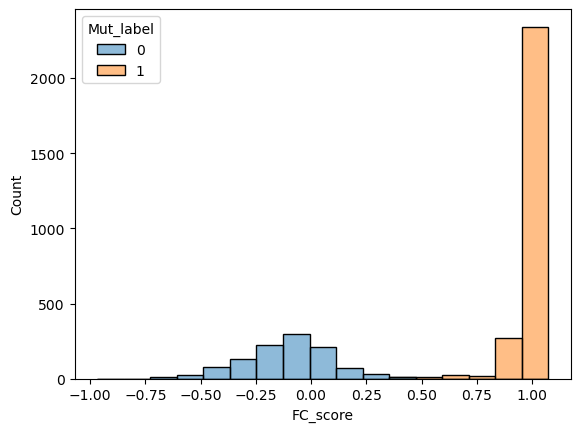

In [90]:
single_muts = pd.concat([fcy1_muts_1nt, indels_FC]).reset_index(drop=True)

sns.histplot(data=single_muts, x='FC_score', hue='Mut_label')

The figure is not really useful, but the fraction of resistance-conferring mutations (FCY1 LOFs) when accounting for indels could be included in the main text.

In [92]:
frac_res_all = (np.sum(single_muts['Mut_label']) / single_muts.shape[0])*100

print(f'{frac_res_all} % of single-nucleotide mutations in FCY1 confer resistance to 5-FC')

70.97716409984068 % of single-nucleotide mutations in FCY1 confer resistance to 5-FC


Assuming that all single-nucleotide indels create a premature stop codon is most likely not accurate and thus not informative! No need to include this.

### Making a histogram showing the selection coefficients of spike-ins, for talks

In [95]:
res_palette = sns.color_palette('viridis', 12)

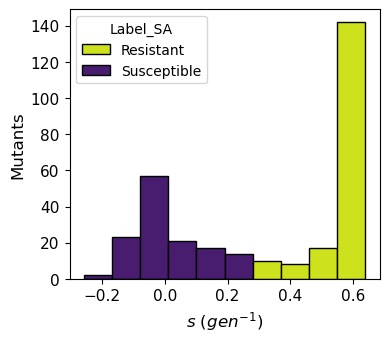

In [96]:
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11

fig, axs = plt.subplots(1,1, figsize=(4, 3.5))
hits_res = sns.histplot(data=s_aa_merged, x='Median_s_T0toT2', hue='Label_SA', ax=axs, palette=[res_palette[-1], res_palette[0]], alpha=1)

axs.set_ylabel('Mutants')
axs.set_xlabel(r"$s$ ($gen^{-1}$)")

s_talk = plt.gcf()
s_talk.savefig(f"Final_figs/hist_s_talk", bbox_inches='tight')

## Exporting the data

In [98]:
# Comparisons between effects, by amino acid
s_aa_merged = s_aa_merged.drop(columns=['Synonymous', 'Class_outcome', 'occurences'])
s_aa_merged.to_csv("Supp_data/CDS_byaa_comparisons.csv", index=False)

# Selection coefficients from the current study, by codon (rather than aa)
s_CDS_calc = s_CDS_calc.drop(columns=['Included_position', 'Mutation_types', 'Synonymous'])
s_CDS_calc.to_csv("Supp_data/CDS_s_bycodon.csv", index=False)

# Effects of single-nucleotide substitutions in FCY1, from Després et al (2022) data by aa
fcy1_muts_1nt['Mut_label'] = fcy1_muts_1nt['Mut_label'].apply(lambda x: dict_labels[x])
fcy1_muts_1nt.to_csv("Supp_data/CDS_1nt_fromDesprés.csv", index=False)